In [1]:
# work environment: jl2815
# Standard libraries
import sys
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle

from sklearn.neighbors import BallTree

# Plotting and visualization
import matplotlib.pyplot as plt

# Type hints
from typing import Callable, Union, Tuple
from pathlib import Path


gems_tco_path = "/Users/joonwonlee/Documents/GEMS_TCO-1/src"
sys.path.append(gems_tco_path)

# Custom imports
from GEMS_TCO import data_preprocess as dmbh
from GEMS_TCO import kernels 
from GEMS_TCO import orderings as _orderings
from GEMS_TCO import load_data
from GEMS_TCO import configuration as config



In [12]:
5/0.044*(10/0.063)

18037.51803751804

# past data investigation

In [8]:
lat_lon_resolution = [1,1]
years = ['2024']
month_range =[7,8]
nheads = 2
mm_cond_number = 10 

day = 3   # 34656
idx_for_datamap= [ 8*(day-1),8*day]
data_load_instance = load_data(config.mac_data_load_path)
df = data_load_instance.read_pickle(config.mac_estimates_day_path,config.mac_full_day_v05_pickle)
map, ord_mm, nns_map= data_load_instance.load_mm20k_data_bymonthyear( lat_lon_resolution= lat_lon_resolution, mm_cond_number=mm_cond_number,years_=years, months_=month_range)
analysis_data_map, aggregated_data = data_load_instance.load_working_data_byday( map, ord_mm, nns_map, idx_for_datamap= idx_for_datamap)

keys = list(analysis_data_map.keys())
hour = 1
print(analysis_data_map[keys[hour-1]].shape)  
print(pd.Series(analysis_data_map[keys[hour-1]][:,2]).nunique())
print(pd.Series(analysis_data_map[keys[hour-1]][:,2]).nunique()/analysis_data_map[keys[hour-1]].shape[0])


#4595/5000  13180/20000 68.11% has unique in previous setting

torch.Size([18126, 4])
17351
0.9572437382765089


In [10]:
output_filepath = '/Users/joonwonlee/Documents/GEMS_DATA/pickle_2024/orbit_map24_07.pkl'

with open(output_filepath, 'rb') as pickle_file:
    ori_map = pickle.load(pickle_file)

output_filepath = '/Users/joonwonlee/Documents/GEMS_DATA/pickle_2024/coarse_cen_map24_07.pkl'

with open(output_filepath, 'rb') as pickle_file:
    coarse_map = pickle.load(pickle_file)

solve resolution error

It turns out that j=1, 2, 4, 8 works fine but other values such as 3, 5, 7 might cause an issue due to rounding error. This is quite complicated because I add 0.00012 to latitude per each longitude movement. 

In [ ]:
j=2
lat_lon_resolution = [j,j]
keys = list(coarse_map.keys())
sample_df = coarse_map[keys[0]]
sample_df = coarse_map[keys[0]]
sample_key = coarse_map.get(keys[0])
if sample_key is None:
    print(f"Key {keys[0]} not found in the dictionary.")


lat_s, lat_e = 0, 5 
step_lat = 0.044
lat_coords = np.arange( lat_e -step_lat - 0.0002, lat_s - step_lat, -step_lat)
sample_df['Latitude'] = sample_df['Latitude'].round(5) 

rho_lat = lat_lon_resolution[0]          
rho_lon = lat_lon_resolution[1]
#lat_n = sample_df['Latitude'].unique()[::rho_lat]
#lon_n = sample_df['Longitude'].unique()[::rho_lon]


unique_lats = sample_df['Latitude'].unique()
sorted_lats_descending = np.sort(unique_lats)[::-1] # Sorts ascending, then reverses
lat_n = sorted_lats_descending[::rho_lat]
unique_lons = sample_df['Longitude'].unique()
sorted_lons_descending = np.sort(unique_lons)[::-1] # Sorts ascending, then reverses
lon_n = sorted_lons_descending[::rho_lon]

print(len(lat_n), len(lon_n))

years = ['2024']
months_ = [7, 8]  # July and August
# Set spatial coordinates for each dataset
coarse_dicts = {}

for year in years:
    for month in range(months_[0], months_[1]):  # Iterate over all months
        loaded_map = coarse_map
        for key in loaded_map:
            tmp_df = loaded_map[key]
            coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
            coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)

print(coarse_dicts['2024_07_y24m07day01_hm00:52'].shape)
print(18126/j**2)

9063 80
(4560, 7)
4531.5


In [ ]:
coarse_dicts['2024_07_y24m07day01_hm00:52'][:50]

In [ ]:
keys = list(ori_map.keys())
for key in keys:
    print( ori_map[key].shape, coarse_map[key].shape)

In [ ]:
class center_matching_hour():
    """
    Processes orbit data by averaging over specified spatial regions and resolutions.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing the data.
        lat_s (int): Start latitude for spatial averaging.
        lat_e (int): End latitude for spatial averaging.
        lon_s (int): Start longitude for spatial averaging.
        lon_e (int): End longitude for spatial averaging.
        lat_resolution (Optional[float]): Latitude resolution for spatial bins. Default is None.
        lon_resolution (Optional[float]): Longitude resolution for spatial bins. Default is None.
    """
    def __init__(
        self, 
        df:pd.DataFrame=None, 
        lat_s:float =5,
        lat_e:float =10, 
        lon_s:float =110,
        lon_e:float =120, 
        lat_resolution:float=None, 
        lon_resolution:float =None
    ):
        # Input validation
        if df is not None:
            assert isinstance(df, pd.DataFrame), "df must be a pandas DataFrame"

        if lat_resolution is not None:
            assert isinstance(lat_resolution, float), "lat_resolution must be a float"
        if lon_resolution is not None:
            assert isinstance(lon_resolution, float), "lon_resolution must be a float"
        
        self.df = df
        self.lat_resolution = lat_resolution
        self.lon_resolution = lon_resolution
        self.lat_s = lat_s
        self.lat_e = lat_e
        self.lon_s = lon_s
        self.lon_e = lon_e

    def group_data_by_orbits(self):
        """
        Groups data into a dictionary based on unique orbit timestamps.

        Returns:
            dict: A dictionary where keys represent formatted orbit identifiers 
                and values are DataFrames corresponding to each orbit.
        """
        orbit_map = {}  
        self.df['Orbit'] = self.df['Time'].str[0:16]
        orbits = self.df['Orbit'].unique()
        for orbit in orbits:
            orbit_key = f'y{orbit[2:4]}m{int(orbit[5:7]):02d}day{ int(orbit[8:10]):02d}_hm{(orbit[11:16])}'
            orbit_map[orbit_key] = self.df.loc[self.df['Orbit'] == orbit].reset_index(drop=True)
        return orbit_map
    


    def make_center_points_backup(self, step_lat:float=0.022, step_lon:float=0.063) -> pd.DataFrame:
        lat_coords = np.arange( self.lat_e-step_lat, self.lat_s -step_lat, -step_lat)
        lon_coords = np.arange( self.lon_e-step_lon, self.lon_s-step_lon, -step_lon)

        # Apply the shift as in the original code
        # These are the unique lat/lon values for the "center_points" grid
        final_lat_values = lat_coords + step_lat
        final_lon_values = lon_coords + step_lon
        
        # Create the grid using vectorized operations
        # This matches the order of the original nested loops (outer lat, inner lon)
        center_lats = np.repeat(final_lat_values, len(final_lon_values))

        # Create a decrement pattern: [0, 1, 2, ..., n_lon-1]
        decrement = 0.00012
        decrements = np.arange(len(final_lon_values)) * decrement

        # Subtract this pattern from each lat value using broadcasting
        center_lats = final_lat_values - decrements
        center_lons = np.tile(final_lon_values, len(final_lat_values))
        
        center_points_df = pd.DataFrame({'lat': center_lats, 'lon': center_lons})
        return center_points_df

    def make_center_points(self, step_lat:float=0.042, step_lon:float=0.062) -> pd.DataFrame:
        lat_coords = np.arange( self.lat_e-step_lat- 0.0002, self.lat_s-step_lat , -step_lat)
        lon_coords = np.arange( self.lon_e-step_lon - 0.0002, self.lon_s-step_lon, -step_lon)

        # Apply the shift as in the original code
        # These are the unique lat/lon values for the "center_points" grid
        final_lat_values = lat_coords + step_lat 
        final_lon_values = lon_coords + step_lon 
        
        # Create 2D grid with broadcasting
        decrement = 0.00012  # this actually help matching the upper latitude slice for given longitude
        lat_grid = final_lat_values[:, None] + np.arange(len(final_lon_values)) * decrement  # shape: (228, 152)

        # Flatten row-wise (C order)
        center_lats = lat_grid.flatten()

        # Create matching longitude grid
        center_lons = np.tile(final_lon_values, len(final_lat_values))

        # Now you can build your DataFrame
        center_points_df = pd.DataFrame({'lat': center_lats, 'lon': center_lons})


        return center_points_df
    

    '''  
    coarse_by_center   allows duplicates while coarse_by_center_unique doesnt.
    '''

    def coarse_by_center(self, orbit_map: dict, center_points: pd.DataFrame) -> dict:
        assert isinstance(orbit_map, dict), "orbit_map must be a dict"
        assert isinstance(center_points, pd.DataFrame), "center_points must be a pd.DataFrame"

        coarse_map = {}
        key_list = sorted(orbit_map)

        # Convert query points (lat, lon) to NumPy array
        query_points = center_points[['lat', 'lon']].to_numpy()
        query_points_rad = np.radians(query_points)  # if using haversine

        num_center_points = len(center_points)

        for key in key_list:
            cur_data = orbit_map[key].reset_index(drop=True)
            locs = cur_data[['Latitude', 'Longitude']].to_numpy()

            if locs.shape[0] == 0:
                coarse_map[key] = pd.DataFrame({
                    'Latitude': center_points['lat'],
                    'Longitude': center_points['lon'],
                    'ColumnAmountO3': [np.nan] * num_center_points,
                    'Hours_elapsed': [np.nan] * num_center_points,
                    'Time': [pd.NaT] * num_center_points,
                    'Source_Latitude': [np.nan] * num_center_points,
                    'Source_Longitude': [np.nan] * num_center_points
                })
                continue

            # Use haversine
            locs_rad = np.radians(locs)
            tree = BallTree(locs_rad, metric='haversine')
            dist, ind = tree.query(query_points_rad, k=1)

            nearest_indices = ind.flatten()

            # Extract values from the nearest source points
            res_o3_values = cur_data.loc[nearest_indices, 'ColumnAmountO3'].values
            source_lat = cur_data.loc[nearest_indices, 'Latitude'].values
            source_lon = cur_data.loc[nearest_indices, 'Longitude'].values

            hours_elapsed_val = cur_data['Hours_elapsed'].iloc[0] if not cur_data.empty else np.nan
            time_val = cur_data['Time'].iloc[0] if not cur_data.empty else pd.NaT

            coarse_map[key] = pd.DataFrame({
                'Latitude': center_points['lat'].values,
                'Longitude': center_points['lon'].values,
                'ColumnAmountO3': res_o3_values,
                'Hours_elapsed': [hours_elapsed_val] * num_center_points,
                'Time': [time_val] * num_center_points,
                'Source_Latitude': source_lat,
                'Source_Longitude': source_lon
            })

        return coarse_map


    def coarse_by_center_unique(self, orbit_map: dict, center_points: pd.DataFrame) -> dict:
        assert isinstance(orbit_map, dict), "orbit_map must be a dict"
        assert isinstance(center_points, pd.DataFrame), "center_points must be a pd.DataFrame"

        coarse_map = {}
        key_list = sorted(orbit_map)

        query_points = center_points[['lat', 'lon']].to_numpy()
        num_center_points = len(center_points)

        for key in key_list:
            cur_data = orbit_map[key].reset_index(drop=True)
            locs = cur_data[['Latitude', 'Longitude']].to_numpy()

            if locs.shape[0] == 0:
                coarse_map[key] = pd.DataFrame({
                    'Latitude': center_points['lat'],
                    'Longitude': center_points['lon'],
                    'ColumnAmountO3': [np.nan] * num_center_points,
                    'Hours_elapsed': [np.nan] * num_center_points,
                    'Time': [pd.NaT] * num_center_points,
                    'Source_Latitude': [np.nan] * num_center_points,
                    'Source_Longitude': [np.nan] * num_center_points
                })
                continue

            # tree = BallTree(locs, metric='euclidean')
            # dist, ind = tree.query(query_points, k=1)

            locs_rad = np.radians(locs)
            query_points_rad = np.radians(query_points)

            tree = BallTree(locs_rad, metric='haversine')
            dist, ind = tree.query(query_points_rad, k=1)

            # Optionally convert to meters (if you care about the actual distance)
            dist_meters = dist * 6371000  # Earth's radius in meters


            nearest_indices = ind.flatten()

            # Deduplicate: keep only the first match per source point
            _, unique_query_indices = np.unique(nearest_indices, return_index=True)
            unique_query_indices = np.sort(unique_query_indices)

            filtered_indices = nearest_indices[unique_query_indices]
            filtered_lat = center_points['lat'].iloc[unique_query_indices].values
            filtered_lon = center_points['lon'].iloc[unique_query_indices].values
            res_o3_values = cur_data.loc[filtered_indices, 'ColumnAmountO3'].values

            source_lat = cur_data.loc[filtered_indices, 'Latitude'].values
            source_lon = cur_data.loc[filtered_indices, 'Longitude'].values

            hours_elapsed_val = cur_data['Hours_elapsed'].iloc[0] if not cur_data.empty else np.nan
            time_val = cur_data['Time'].iloc[0] if not cur_data.empty else pd.NaT

            coarse_map[key] = pd.DataFrame({
                'Latitude': filtered_lat,
                'Longitude': filtered_lon,
                'ColumnAmountO3': res_o3_values,
                'Hours_elapsed': [hours_elapsed_val] * len(filtered_lat),
                'Time': [time_val] * len(filtered_lat),
                'Source_Latitude': source_lat,
                'Source_Longitude': source_lon
            })

        return coarse_map



In [6]:
base_path = config.mac_data_load_path
output_path = base_path
lat_start, lat_end, lon_start, lon_end = 0, 5, 123, 133
# lat_start, lat_end, lon_start, lon_end = 9.0, 9.003, 113.45, 123.55

# df = pd.read_csv("C:\\Users\\joonw\\TCO\\GEMS_data\\data_2024\\data_24_07_0131_N510_E110120.csv")  MSI notebook
df = pd.read_csv("/Users/joonwonlee/Documents/GEMS_DATA/data_2024/data_24_07_0131_N05_E123133.csv")  # MAC
instance = dmbh.center_matching_hour(df, lat_start, lat_end, lon_start, lon_end)  


### Experiment regular grids

In [36]:
step_lat_list = [0.044]  #  0.05 0.05 is not really good
step_lon_list = [0.063]      
lon_start_list = [123.0]
for lon_start in lon_start_list:
    instance = dmbh.center_matching_hour(df, lat_start, lat_end, lon_start, lon_end) 
    #instance = center_matching_hour(df, lat_start, lat_end, lon_start, lon_end)  
    for step_lat in step_lat_list:
        for step_lon in step_lon_list:
            center_points = instance.make_center_points(step_lat = step_lat, step_lon= step_lon)
            coarse_cen_map = instance.coarse_by_center(ori_map, center_points)
  
            # coarse_cen_map3 = instance.coarse_by_center_unique(data_map_hour, center_points)
            res = []
            keys_list = list(coarse_cen_map.keys())
            for key in keys_list:
                tmp  =coarse_cen_map[key]['ColumnAmountO3'].nunique()/ coarse_cen_map[key].shape[0]*100
                print(tmp)
                res.append(tmp)
            res = np.array(res)
            print(f' step_lat: {step_lat}, step_lon: {step_lon}, averaged nunqiue is {np.mean(res)}')


97.9808010592519
92.24870351980582
89.65022619441686
88.29857663025489
76.48681452057818
83.3940196402957
85.43528632903012
85.06013461326272
98.05803817720403
96.84431203795653
96.32571996027805
96.38088933024385
83.8519254110118
85.77733642281805
85.77733642281805
85.60631137592408
95.7243738276509
93.8375813748207
93.15348118724485
93.8651660598036
81.63411673838685
83.59262937217257
86.05318327264703
85.67803155687962
98.13527529515613
94.240317775571
93.30243848615248
93.58380227297805
81.72238773033213
83.34988414432307
86.11938651660597
85.56217587995145
97.34083636764869
95.62506896171246
95.50369634778771
95.38784067085953
84.4974070396116
85.69458236786936
85.90422597373937
85.64492993490013
97.15326050976498
97.29670087167605
96.64018536908308
96.29261833829858
84.34293280370738
84.83945713339953
85.40770164404722
84.99393136930377
97.88149619331348
96.89396447092574
96.76707492000442
96.60156681010703
85.04910073926956
85.93732759571886
86.02008165066755
85.738717863842
97.

In [ ]:
coarse_cen_map[keys_list[4]][900:950]

Look at longitude steps

In [244]:
j=6

a = ori_map[keys_list[j]]['Longitude']- ori_map[keys_list[j]]['Longitude'].shift()
a[abs(a)>0.001].head(50)

1    -0.06262
2    -0.06284
3    -0.06180
4    -0.06312
5    -0.06256
6    -0.06211
7    -0.06318
8    -0.06150
9    -0.06338
10   -0.06252
11   -0.06211
12   -0.06337
13   -0.06188
14   -0.06317
15   -0.06235
16   -0.06236
17   -0.06267
18   -0.06297
19   -0.06195
20   -0.06276
21   -0.06319
22   -0.06201
23   -0.06247
24   -0.06213
25   -0.06311
26   -0.06243
27   -0.06213
28   -0.06291
29   -0.06267
30   -0.06195
31   -0.06287
32   -0.06274
33   -0.06192
34   -0.06328
35   -0.06175
36   -0.06261
37   -0.06257
38   -0.06273
39   -0.06191
40   -0.06245
41   -0.06304
42   -0.06232
43   -0.06196
44   -0.06256
45   -0.06404
46   -0.06079
47   -0.06360
48   -0.06205
49   -0.06228
50   -0.06316
Name: Longitude, dtype: float64

This is average value for longitude, but we should be careful when looking at the average value for latitude because there are too small steps in latitude that change average value. For example, most of the steps in latitude could be 0.0045 but there are so many 0.0001 that affect the average and make it something like 0.002.

-0.06238989379468428
-0.06757498583552651
-0.06952682941140702
-0.07107748621771963
-0.07200947817070508
-0.06488977592082841
-0.06225585706638115
-0.062256493889763787
-0.06251359391320992
-0.06371548863826698
-0.06373446351057302
-0.06411784600291513
-0.06435284701117772
-0.062488899259492664
-0.0623179904887881
-0.062223117765602375
-0.06388707338908847
-0.0665284993729036
-0.06736223767756418
-0.06657651454720898
-0.06750209302325581
-0.06501778598112466
-0.06222774320536642
-0.06232964678451018
-0.062467938603684874
-0.06569729413625514
-0.06631394088240423
-0.06628165065236298
-0.06609301880972339
-0.06458768881187471
-0.062289078235460454
-0.062244133837191004
-0.06306913231397658
-0.06471747932362772
-0.06467894770574556
-0.06435821796031431
-0.0641057946848997
-0.06271677975851823
-0.06235876542859843
-0.06224600591976824
-0.06288418764616865
-0.06334041603169764
-0.0637233637704553
-0.06365453474967979
-0.06399619285391518
-0.06325543862060151
-0.06236915517728714
-0.06231806

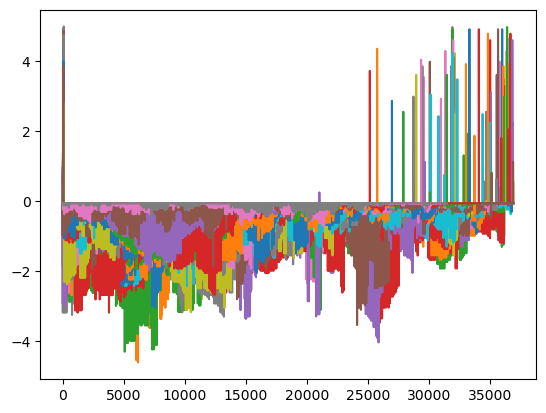

In [121]:
res = []
for key in keys:

    a = data_map_hour[key]['Longitude']-data_map_hour[key]['Longitude'].shift()
    a = a[ abs(a)<5]
    plt.plot(a[1:])
    res.append(a[abs(a)>0.001].mean())
    print(a[abs(a)>0.001].mean())

print(f'total mean: {np.mean(np.array(res))}')

Look at latitude steps

In [29]:
j=19

a = ori_map[keys_list[j]]['Latitude']- ori_map[keys_list[j]]['Latitude'].shift()
a[abs(a)>0.001].head(50)

122    -0.040580
227     0.001045
275    -0.047240
431    -0.047234
589    -0.047228
745    -0.047223
882     0.001236
900    -0.047217
1036    0.001233
1054   -0.047211
1189    0.001143
1206   -0.047205
1340    0.001491
1356   -0.047199
1488    0.001239
1504   -0.047194
1653   -0.047188
1802   -0.047182
1917    0.001069
1948   -0.047176
2062    0.001307
2075    0.001231
2091   -0.047170
2204    0.001305
2217    0.001765
2231   -0.047165
2344    0.001096
2358    0.002099
2371   -0.047159
2501    0.002095
2514   -0.047153
2648    0.002009
2660   -0.047147
2795    0.002006
2807   -0.047141
2942    0.002194
2954   -0.047135
3091    0.001747
3104   -0.047130
3241    0.001995
3253   -0.047125
3389    0.001992
3401   -0.047118
3537    0.001988
3549   -0.047112
3683    0.002091
3694   -0.047107
3824    0.001981
3836   -0.047101
3967    0.002083
Name: Latitude, dtype: float64

Now see how average values in latitude is distorted below

-0.04497890904773915
-0.02261629203869179
-0.021118895259808906
-0.018728115966464846
-0.01884503149381551
-0.03120960880546075
-0.04017507678156522
-0.03929356795326087
-0.044110689263043464
-0.03653152008172043
-0.0358952759928512
-0.03455617991055366
-0.0357849155891635
-0.040587048097886984
-0.040597961581
-0.03885550584676521
-0.0344106786601275
-0.02926216513949716
-0.027988788346525198
-0.02913082591903047
-0.023320022198749988
-0.031103059360833327
-0.04107351412695652
-0.04069133003308696
-0.04514239396891306
-0.029698448176525616
-0.0293117826808023
-0.025981242414627237
-0.0278062370050944
-0.03095758489873684
-0.04038571709191304
-0.039234050879086955
-0.04355874982393305
-0.03592615956707316
-0.034002766232263164
-0.03642543608602838
-0.03475785583602941
-0.0400893795714706
-0.03978604954156522
-0.04069696699169565
-0.04222810924582645
-0.04047434557908266
-0.04063521018820866
-0.037841993701697406
-0.0368740051265873
-0.038843495491560166
-0.040831515011353695
-0.04024590

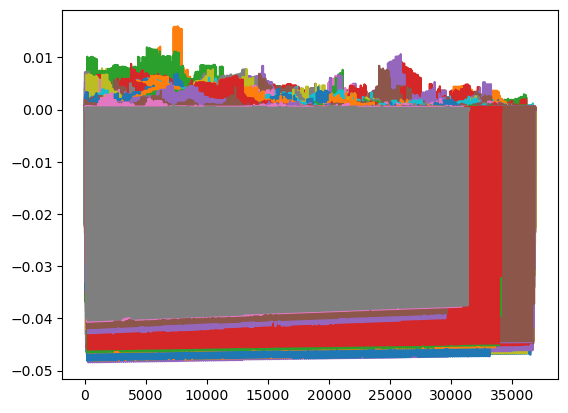

In [184]:

res = []
for key in keys:

    a = ori_map[key]['Latitude']-data_map_hour[key]['Latitude'].shift()
    a = a[ abs(a)<5]
    plt.plot(a[1:])
    res.append(a[abs(a)>0.001].mean())
    print(a[abs(a)>0.001].mean())

print(f'total mean: {np.mean(np.array(res))}')